# Assembly QC Analysis & Plots

In [1]:
import sys
import os
import glob
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

## BUSCO's results

In [2]:
def get_status_set(dataFrame, status):
    if isinstance(dataFrame, (list, tuple)):
        return [get_status_set(el, status) for el in dataFrame]
    elif not isinstance(dataFrame, pd.DataFrame):
        raise NotImplementedError()
        
    return set(dataFrame.loc[dataFrame["Status"] == status, "BuscoId"].values)

def status_intersection(status_set):
    results = []
    for i in range(len(status_set)-1):
        for j in range(i+1, len(status_set)):
            intersection = status_set[i].intersection(status_set[j])
            results.append(len(intersection))
            
    return results

def pretty_print_status_intersection(status_set, status_intersection, status):
    print(f"{status} Intersection")
    k = 0
    for i in range(len(status_set)-1):
        for j in range(i+1, len(status_set)):
            len_set_i = f"Len Set {i}".ljust(20, '.') + f"{len(status_set[i])}".rjust(5, '.')
            len_set_j = f"Len Set {j}".ljust(20, '.') + f"{len(status_set[j])}".rjust(5, '.')
            len_intersection = f"Len intersection".rjust(5, '.') + f"{status_intersection[k]}".rjust(5, '.')
            print("\t" + len_set_i + " || " + len_set_j + " || " + len_intersection)
            k += 1

In [3]:
files = glob.glob("./out/assemly_qc/*/busco/polished_full_table.tsv")
files = [(os.path.basename(file)[:-4], file) for file in files]

colNames = ["BuscoId", "Status", "Sequence", "GeneStart", "GeneEnd", "Strand", "Score", "Length", "OrthoDBUrl", "Description"]
files = [(file[0], pd.read_csv(file[1], sep="\t", comment="#", names=colNames)) for file in files]

duplicated_set = get_status_set([file[1] for file in files], "Duplicated")
duplicated_intersection = status_intersection(duplicated_set)
pretty_print_status_intersection(duplicated_set, duplicated_intersection, "Duplicated")

missing_set = get_status_set([file[1] for file in files], "Missing")
missing_intersection = status_intersection(missing_set)
pretty_print_status_intersection(missing_set, missing_intersection, "Missing")

fragmented_set = get_status_set([file[1] for file in files], "Fragmented")
fragmented_intersection = status_intersection(fragmented_set)
pretty_print_status_intersection(fragmented_set, fragmented_intersection, "Fragmented")

Duplicated Intersection
	Len Set 0..............73 || Len Set 1..............69 || Len intersection...66
Missing Intersection
	Len Set 0..............50 || Len Set 1..............34 || Len intersection...34
Fragmented Intersection
	Len Set 0...............7 || Len Set 1...............5 || Len intersection....4


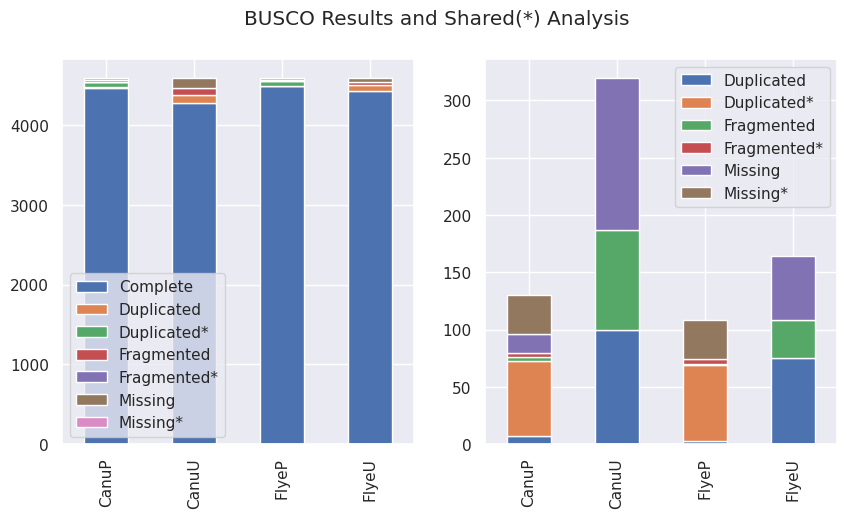

In [4]:
buscos_stats = pd.DataFrame({"Complete":       [4466, 4276, 4488, 4432],
                             "Duplicated":     [   7,  100,    3,   75],
                             "Duplicated*":    [  66,    0,   66,    0],
                             "Fragmented":     [   3,   87,    1,   33],
                             "Fragmented*":    [   4,    0,    4,    0],
                             "Missing":        [  16,  133,    0,   56],
                             "Missing*":       [  34,    0,   34,    0]},
                             index = ["CanuP", "CanuU", "FlyeP", "FlyeU"])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("BUSCO Results and Shared(*) Analysis")
buscos_stats.plot(kind='bar', stacked=True, ax=axes[0])
buscos_stats.iloc[:, 1:].plot(kind='bar', stacked=True, ax=axes[1])
plt.show()

## QUAST's results

In [7]:
def parse_gaps_file(file):
    if isinstance(file, (tuple, list)):
        return [parse_gaps_file(el) for el in file]
    elif not isinstance(file, str):
        raise NotImplementedError()
        
    parsed_file = {}
    with open(file) as f:
        chromosome = ''
        for line in f.readlines():
            line = line.rstrip()
            
            # Parse new chromosomes
            re_chromosome_name = r"^(?P<chromosome_name>\w*_dna_chromosome)_\S*$"
            match = re.match(re_chromosome_name, line)
            if match:
                chromosome = match.groupdict()['chromosome_name']
                parsed_file[chromosome] = []
                continue
                
            # Get gap start/stop
            re_start_stop = r"^(?P<gap_start>\d*)\s(?P<gap_stop>\d*)$"
            match = re.match(re_start_stop, line)
            parsed_file[chromosome].append((int(match.groupdict()['gap_start']), int(match.groupdict()['gap_stop'])))
            
    return parsed_file

def compare_gaps_files(files):
    if not isinstance(files, list) and not len(files) == 2:
        raise NotImplementedError()
        
    if not all([key in files[1].keys() for key in files[0].keys()]) or len(files[0]) != len(files[1]):
        raise ValueError()
    
    overlaps = {}
    for key in files[0].keys():
        overlaps[key] = compare_gaps_chromosome([el[key] for el in files])
        
    return overlaps
        
def compare_gaps_chromosome(chromosomes):
    if not isinstance(chromosomes, list) and not len(chromosomes) == 2:
        raise NotImplementedError()
        
    if not all(chromosomes):
        return 0
        
    max_len = max(chromosomes[0][-1][1], chromosomes[1][-1][1])
    overlap = np.zeros((max_len, 2))
    
    for i, chromosome in enumerate(chromosomes):
        for gap in chromosome:
            overlap[gap[0]:gap[1], i] = 1
            
    overlap = np.apply_over_axes(np.sum, overlap, axes=1)
    return np.count_nonzero(overlap == 2)

In [8]:
files = glob.glob("./out/assemly_qc/*/quast/polished/genome_stats/assembly-*_gaps.txt")
files = parse_gaps_file(files)
compare_gaps_files(files)

{'1_dna_chromosome': 3221025,
 '3_dna_chromosome': 2638565,
 '5_dna_chromosome': 2828861,
 'Pt_dna_chromosome': 0,
 '4_dna_chromosome': 2238796,
 'Mt_dna_chromosome': 0,
 '2_dna_chromosome': 2232549}

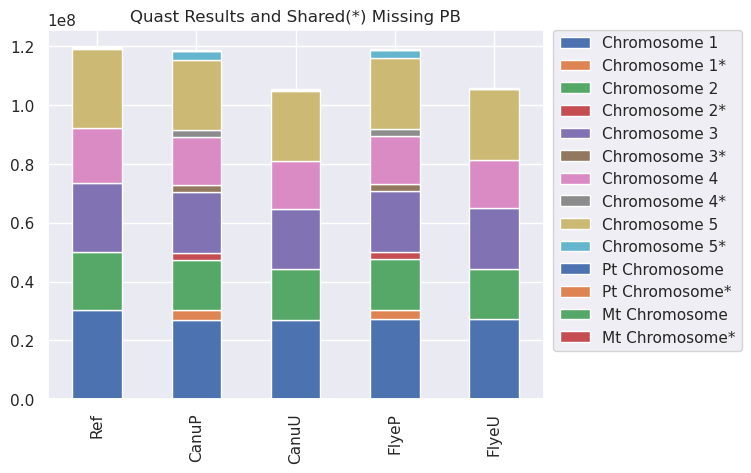

In [22]:
quast_stats = pd.DataFrame({"Chromosome 1":   [30427671, 26938709, 26904797, 27089601, 27092859],
                        "Chromosome 1*":      [       0,  3221025,        0,  3221025,        0],
                        "Chromosome 2":       [19698289, 17272351, 17208639, 17355234, 17318719],
                        "Chromosome 2*":      [       0,  2232549,        0,  2232549,        0],
                        "Chromosome 3":       [23459830, 20676444, 20651177, 20758539, 20748333],
                        "Chromosome 3*":      [       0, 2638565,        0,   2638565,        0],
                        "Chromosome 4":       [18585056, 16208329, 16189440, 16246045, 16230706],
                        "Chromosome 4*":      [       0,  2238796,        0,  2238796,        0],
                        "Chromosome 5":       [26975502, 23982293, 23985264, 24072746, 24074545],
                        "Chromosome 5*":      [       0,  2828861,        0,  2828861,        0],
                        "Pt Chromosome":      [  154478,   154478,   154478,    59074,    56783],
                        "Pt Chromosome*":     [       0,        0,        0,        0,        0],
                        "Mt Chromosome":      [  366924,   332173,   332173,   300090,   300090],
                        "Mt Chromosome*":     [       0,        0,        0,        0,        0]},
                       index =                ["Ref"   , "CanuP" , "CanuU" , "FlyeP", "FlyeU"])

quast_stats.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Quast Results and Shared(*) Missing PB")
plt.show()